In [1]:
import numpy as np
import matplotlib as mpl
mpl.use('pgf')

def textwidth_to_inch(scale):
    fig_width_pt = 427.3153                         # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    return fig_width_pt*inches_per_pt*scale         # width in inches

def figsize(scale):
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = textwidth_to_inch(scale)
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    "font.size": 10,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.figsize": figsize(0.9),     # default fig size of 0.9 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }
mpl.rcParams.update(pgf_with_latex)

import matplotlib.pyplot as plt

# I make my own newfig and savefig functions
def newfig(width):
    plt.clf()
    fig = plt.figure(figsize=figsize(width))
    ax = fig.add_subplot(111)
    return fig, ax

def savefig(filename):
    plt.savefig('../../text/figures/plots/{}.pgf'.format(filename), bbox_inches='tight')
    plt.savefig('../../text/figures/plots/{}.pdf'.format(filename), bbox_inches='tight')

%matplotlib inline

import pandas as pd

import json
import glob
import os

from math import log

import seaborn as sns
sns.set_style("whitegrid")
mpl.rcParams.update(pgf_with_latex)

In [3]:
data = {}

for path in glob.glob(os.path.expanduser("~/dev/ma/data/results/plm_scaling/*.json")):
  for typename, items in json.load(open(path)).items():
    if typename in data:
      data[typename].update(items)
    else:
      data[typename] = items

frames = { typename: pd.DataFrame.from_dict(items, orient='index') for typename, items in data.items() }

graph_names = {
    '/home/kit/iti/kp0036/graphs/mu-04/graph_50_10000_mu_0.4_100000-sorted-preprocessed-*.bin': 'LFR 100K', 
    '/home/kit/iti/kp0036/graphs/mu-04/graph_50_10000_mu_0.4_1000000-preprocessed-*.bin': 'LFR 1M', 
    '/home/kit/iti/kp0036/graphs/mu-04/graph_50_10000_mu_0.4_10000000-preprocessed-*.bin': 'LFR 10M', 
    '/home/kit/iti/kp0036/graphs/mu-04/graph_50_10000_mu_0.4_100000000-preprocessed-*.bin': 'LFR 100M', 
    '/home/kit/iti/kp0036/graphs/mu-04/graph_50_10000_mu_0.4_200000000-sorted-preprocessed-*.bin': 'LFR 200M', 
    '/home/kit/iti/kp0036/graphs/hypercubegraph23-preprocessed-*.bin': 'hypercube', 
    '/home/kit/iti/kp0036/graphs/uk-2002.metis-preprocessed-*.bin': 'uk-2002', 
    '/home/kit/iti/kp0036/graphs/uk-2007-05.metis-preprocessed-*.bin': 'uk-2007-05', 
    '/home/kit/iti/kp0036/graphs/in-2004.metis-preprocessed-*.bin': 'in-2004', 
    '/home/kit/iti/kp0036/graphs/com-friendster-preprocessed-*.bin': 'com-friendster', 
    '/home/kit/iti/kp0036/graphs/com-lj.ungraph-preprocessed-*.bin': 'com-lj', 
    '/home/kit/iti/kp0036/graphs/com-orkut.ungraph-preprocessed-*.bin': 'com-orkut', 
    '/home/kit/iti/kp0036/graphs/com-youtube.ungraph-preprocessed-*.bin': 'com-youtube', 
    '/home/kit/iti/kp0036/graphs/com-amazon.ungraph-preprocessed-*.bin': 'com-amazon'
}

frames['program_run'].replace({ 'graph': graph_names }, inplace=True)

In [4]:
frames['program_run']['worker_label'] = frames['program_run']['hosts'].map(str) + 'x' + frames['program_run']['workers_per_host'].map(str)

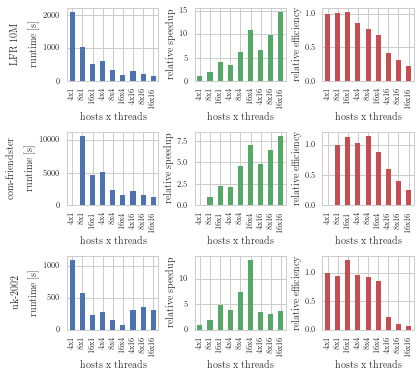

In [18]:
fig, axes = plt.subplots(3, 3, figsize=(textwidth_to_inch(1.05), textwidth_to_inch(1)));
plt.subplots_adjust(wspace=0.4, hspace=0.7);
pad = 5

grouped_by_graph = frames['clustering'] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True, how='right') \
    .groupby('graph')
    
for i, (graph, graph_data) in enumerate(grouped_by_graph):
    plot_data = graph_data \
        .groupby('worker_label')[['runtime', 'total_workers', 'modularity']].mean() \
        .sort_values(by='total_workers')
    plot_data['speedup'] = plot_data['runtime'].dropna().iloc[0] / plot_data['runtime']
    plot_data['efficiency'] = plot_data.dropna()['total_workers'].iloc[0] * plot_data['speedup'] / plot_data['total_workers']
    
    plot_data.plot.bar(y='runtime', legend=False, ax=axes[i][0])
    axes[i][0].set_ylabel("runtime [s]")
    axes[i][0].set_xlabel("hosts x threads")
    
    plot_data.plot.bar(y='speedup', legend=False, ax=axes[i][1], color='C1')
    axes[i][1].set_ylabel("relative speedup")
    axes[i][1].set_xlabel("hosts x threads")
    
    plot_data.plot.bar(y='efficiency', legend=False, ax=axes[i][2], color='C2')
    axes[i][2].set_ylabel("relative efficiency")
    axes[i][2].set_xlabel("hosts x threads")
    
#     if graph == 'com-friendster':
#         axes[i][2].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: "{0:.2f}".format(x).lstrip('0')))
#     else:
#         axes[i][2].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: "{0:.3f}".format(x).lstrip('0')))
#     plot_data.plot.bar(y='modularity', legend=False, ax=axes[i][2], color='C2', ylim=mod_limits[graph])
#     axes[i][2].set_ylabel("modularity")
#     axes[i][2].set_xlabel("hosts x threads")
    
    axes[i][0].annotate(graph, xy=(0, 0.5), xytext=(-axes[i][0].yaxis.labelpad - pad, 0),
                xycoords=axes[i][0].yaxis.label, textcoords='offset points',
                ha='right', va='center', rotation=90)
    
savefig("plm_scaling")

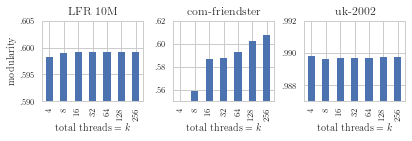

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(textwidth_to_inch(1.1), textwidth_to_inch(0.25)));
plt.subplots_adjust(wspace=0.3)

mod_limits = { 'LFR 10M': (0.59, 0.605), 'uk-2002': (0.987, 0.992), 'com-friendster': (0.55, 0.62) }
    
for i, (graph, graph_data) in enumerate(grouped_by_graph):
    plot_data = graph_data \
        .groupby('total_workers')[['modularity']].mean()
    
    if graph == 'com-friendster':
        axes[i].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: "{0:.2f}".format(x).lstrip('0')))
    else:
        axes[i].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: "{0:.3f}".format(x).lstrip('0')))
    plot_data.plot.bar(y='modularity', legend=False, ax=axes[i], ylim=mod_limits[graph])
    axes[i].set_ylabel("")
    axes[i].set_xlabel("total threads = $k$")
    
    axes[i].set_title(graph)
    
axes[0].set_ylabel("modularity")
savefig("plm_scaling_mod")